In [1]:
import numpy
# библотека scipy.special с сигмоидой expit(), and its inverse logit()
import scipy.special
# scipy.ndimage for rotating image arrays
import scipy.ndimage
# библиотека для графического отображения массивов
import matplotlib.pyplot
# гарантировать размещение графики в данном блокноте, а не в отдельном окне
%matplotlib inline

In [2]:
# helper to load data from PNG image files
import imageio
# glob helps select multiple files using patterns
import glob

In [3]:
# определение класса нейронной сети
class neuralNetwork:
    
    # иницилизировать нейронную сеть
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # задать количество усзорв во входном, скрытом и выходном слое
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # Матрицы весовых коэффициентов связей wih (между входным и скрытым слоями) и who (между скрытым и выходными слоями).
        # Весовые коэффициенты связей между узлом i и узлом j следующего слоя обозначены как w_i_j:
        # w11 w21
        # w12 w22 и т.д.
        self.wih = numpy.random.normal(0.0, self.hnodes ** -0.5, (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, self.onodes ** -0.5, (self.onodes, self.hnodes))
        
        # коэффициент обучения
        self.lr = learningrate
        
        # использование сигмоиды в качестве функции активации
        self.activation_function = lambda x: scipy.special.expit(x)
        self.inverse_activation_function = lambda x: scipy.special.logit(x)
        
        pass
    
    # тренировка нейронной сети
    def train(self, inputs_list, targets_list):
        # преобразовать список входных значений  в двумерный массив
        inputs = numpy.array(inputs_list, ndmin = 2).T
        targets = numpy.array(targets_list, ndmin = 2).T
        
        # рассчитать входящие сигналы для скрытого слоя
        hidden_inputs = numpy.dot(self.wih, inputs)
        # рассчитать исходящие сигналы для скрытого слоя
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # рассчитать входящие сигналы для выходного слоя
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # рассчитать исходящие сигналы для выходного слоя
        final_outputs = self.activation_function(final_inputs)
        
        # ошибки выходного слоя = (целевое значение - фактическое значение)
        output_errors = targets - final_outputs
        # ошибки скрытого слоя - это ошибки output_errors,
        # распределенные пропорционально весовым коэффициентам связей
        # и рекомбинированные на скрытых узлах
        hidden_errors = numpy.dot(self.who.T, output_errors)
        
        # обновить весовые коэффциенты для связей между скрытым и выходным слоями
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)),
                                       numpy.transpose(hidden_outputs))
        
        # обновить весовые коэффициенты для связей между выходным и скрытым слоями
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
        
        pass
    
    # опрос нейронной сети
    def query(self, inputs_list):
        # преобразовать список входных значений  в двумерный массив
        inputs = numpy.array(inputs_list, ndmin = 2).T
        
        # рассчитать входящие сигналы для скрытого слоя
        hidden_inputs = numpy.dot(self.wih, inputs)
        # рассчитать исходящие сигналы для скрытого слоя
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # рассчитать входящие сигналы для выходного слоя
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # рассчитать исходящие сигналы для выходного слоя
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    
    
    # backquery the neural network
    # we'll use the same termnimology to each item, 
    # eg target are the values at the right of the network, albeit used as input
    # eg hidden_output is the signal to the right of the middle nodes
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [4]:
# количество входных, скрытых и выходных узлов
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

# коэффициент обучения равен 0.3
learning_rate = 0.01

# создать экзмепляр нейронной сети
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [5]:
# загрузить в список тренировочный набор данных CSV-файла набора MNIST
training_data_file = open("mnist_dataset/mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

# тренировка нейронной сети

# переменная epochs указывает, сколько раз тренировочный набор данных используется для тренировки сети
epochs = 10

for e in range(epochs):
    # перебрать все записи в тренировочном наборе данных
    for record in training_data_list:
        # получить список значений, используя исмовлы запятой (',') в качестве разделителей
        all_values = record.split(',')
        # масштабировать и сместить входные значения
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # создать целевые выходные значения (все равы 0,01, за исключением желаемого маркерного значения, равного 0,99)
        targets = numpy.zeros(output_nodes) + 0.01

        # all_values[0] - целевое маркерное значение для данной записи
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        
        ## create rotated variations
        # rotated anticlockwise by x degrees
        inputs_plusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), 10, cval=0.01, order=1, reshape=False)
        n.train(inputs_plusx_img.reshape(784), targets)
        # rotated clockwise by x degrees
        inputs_minusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), -10, cval=0.01, order=1, reshape=False)
        n.train(inputs_minusx_img.reshape(784), targets)
        
        pass
    pass

In [6]:
# загрузить в список тестовый набор данных CSV-файла набора MNIST
test_data_file = open("mnist_dataset/mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

# тестирование нейронной сети

# журнал оценок работы сети, первоначально пустой
scorecard = []

# перебрать все записи в тестовом наборе данных
for record in test_data_list:
    # получить список значений из записи, используя символы запятой (',') в качестве разделителя
    all_values = record.split(',')
    # правильный ответ - первое знчение
    correct_label = int(all_values[0])
    # масштабировать и сместить входные значения
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # опрос сети
    outputs = n.query(inputs)
    # индекс наибольшего значения является маркерным значением
    label = numpy.argmax(outputs)
    # присоединить оценку ответа сети к концу списка
    if (label == correct_label):
        # в случае правильного ответа сети присоединить к списку значение 1
        scorecard.append(1)
    else:
        # в случае неправильного ответа сети присоединить к списку значение 0
        scorecard.append(0)
        pass
    
    pass

In [7]:
# рассчитать показатель эффективность в виде доли правильных ответов
scorecard_array = numpy.asarray(scorecard)
print("эффективность = ", scorecard_array.sum() / scorecard_array.size)

эффективность =  0.9782


In [8]:
# our own image test data set
our_own_dataset = []

# load the png image data as test data set
for image_file_name in glob.glob('own_images/2828_my_own_?.png'):
    
    # use the filename to set the correct label
    label = int(image_file_name[-5:-4])
    
    # load image data from png files into an array
    print ("loading ... ", image_file_name)
    img_array = imageio.imread(image_file_name, as_gray=True)
    
    # reshape from 28x28 to list of 784 values, invert values
    img_data  = 255.0 - img_array.reshape(784)
    
    # then scale data to range from 0.01 to 1.0
    img_data = (img_data / 255.0 * 0.99) + 0.01
    print(numpy.min(img_data))
    print(numpy.max(img_data))
    
    # append label and image data  to test data set
    record = numpy.append(label,img_data)
    our_own_dataset.append(record)
    
    pass

loading ...  own_images\2828_my_own_2.png
0.01
1.0
loading ...  own_images\2828_my_own_3.png
0.01
1.0
loading ...  own_images\2828_my_own_4.png
0.01
0.93011767
loading ...  own_images\2828_my_own_5.png
0.01
0.86800003
loading ...  own_images\2828_my_own_6.png
0.01
1.0
loading ...  own_images\2828_my_own_8.png
0.01
1.0


[[0.01072242]
 [0.00690919]
 [0.00889248]
 [0.0287408 ]
 [0.02544746]
 [0.04160629]
 [0.02241373]
 [0.0217405 ]
 [0.25820016]
 [0.00125538]]
network says  8
match!


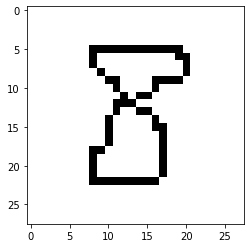

In [9]:
# test the neural network with our own images

# record to test
item = 5

# plot image
matplotlib.pyplot.imshow(our_own_dataset[item][1:].reshape(28,28), cmap='Greys', interpolation='None')

# correct answer is first value
correct_label = our_own_dataset[item][0]
# data is remaining values
inputs = our_own_dataset[item][1:]

# query the network
outputs = n.query(inputs)
print (outputs)

# the index of the highest value corresponds to the label
label = numpy.argmax(outputs)
print("network says ", label)
# append correct or incorrect to list
if (label == correct_label):
    print ("match!")
else:
    print ("no match!")
    pass

[0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01]


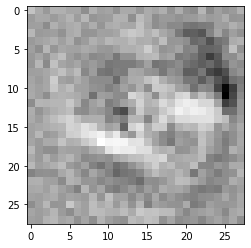

In [19]:
# run the network backwards, given a label, see what image it produces

# label to test
label = 5
# create the output signals for this label
targets = numpy.zeros(output_nodes) + 0.01
# all_values[0] is the target label for this recordе
targets[label] = 0.99
print(targets)

# get image data
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')